In [78]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/', one_hot=False)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [79]:
x_treinamento = mnist.train.images
y_treinamento = mnist.train.labels
x_teste = mnist.test.images
y_teste = mnist.test.labels

In [80]:
y_treinamento = np.asarray(y_treinamento, dtype = np.int32)
y_teste = np.asarray(y_teste, dtype = np.int32)

In [81]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [82]:
# realliza as 4 etapas
def cria_rede(features, labels, mode):
    entrada = tf.reshape(features['x'], [-1, 28, 28, 1]) # batch_size, largura, altura, canais
    
    # Recebe uma imagem com parametros [batch_size, 28, 28, 1]
    # Retorna [batch_size, 28x28 , 32] # 32 filtros aplicados
    convolucao1 = tf.layers.conv2d(inputs = entrada, filters = 32, kernel_size = [5,5],
                                  activation = tf.nn.relu, padding = 'same')
    # Retorna [batch_size, 14x14, 32]
    pooling1 = tf.layers.max_pooling2d(inputs = convolucao1, pool_size = [2,2], strides = 2)
    
    # Retorna [batch_size, 14x14, 64]
    convolucao2 = tf.layers.conv2d(inputs = pooling1, filters = 64, kernel_size = [5,5],
                                  activation = tf.nn.relu, padding = 'same')
    
    # Retorna [batch_size, 7x7, 64]
    pooling2 = tf.layers.max_pooling2d(inputs = convolucao2, pool_size = [2,2], strides = 2)
    
    # Retorna [batch_size, 3136]
    flattening = tf.reshape(pooling2, [-1, 7 * 7 * 64])
    
    # 3136 (Entradas) -> 1024 (camada oculta) -> 10 (saidas)
    densa = tf.layers.dense(inputs = flattening, units = 1024, activation = tf.nn.relu)
    
    # dropout ->zera alguns valores de entrada para melhorar o desempenho e não deixar tao complexo (1024 x 3136 = pesos)
    # o parametro training = mode serve para dar o dropout somente quando for treinamento
    dropout = tf.layers.dropout(inputs = densa, rate = 0.2, training = mode == tf.estimator.ModeKeys.TRAIN)
    
    saida = tf.layers.dense(inputs = dropout, units = 10)
    
    # 0.2 0.2 0.6 = 2
    previsoes = tf.argmax(saida, axis = 1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = previsoes)
    
    erro = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = saida)
    
    # quando nao for treinamento, nao precisa treinar e otimizar
    if mode == tf.estimator.ModeKeys.TRAIN:
        otimizador = tf.train.AdamOptimizer(learning_rate = 0.001)
        treinamento = otimizador.minimize(erro, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = erro, train_op = treinamento)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {'accuracy': tf.metrics.accuracy(labels = labels, predictions = previsoes)}
        return tf.estimator.EstimatorSpec(mode = mode, loss = erro, eval_metric_ops = eval_metric_ops)
    
    

In [ ]:
classificador = tf.estimator.Estimator(model_fn = cria_rede)

In [ ]:
funcao_treinamento = tf.estimator.inputs.numpy_input_fn(x = {'x': x_treinamento}, y = y_treinamento,
                                                       batch_size = 128, num_epochs = None, shuffle = True)
classificador.train(input_fn = funcao_treinamento, steps = 200)

In [ ]:
funcao_teste = tf.estimator.inputs.numpy_input_fn(x = {'x': x_teste}, y = y_teste, num_epochs = 1, shuffle = False)

resultados = classificador.evaluate(input_fn = funcao_teste)

In [86]:
resultados

{'accuracy': 0.9745, 'loss': 0.079030864, 'global_step': 200}

In [87]:
x_imagem_teste = x_teste[0]
x_imagem_teste.shape

(784,)

In [88]:
x_imagem_teste = x_imagem_teste.reshape(1,-1)
x_imagem_teste.shape

(1, 784)

In [ ]:
funcao_previsao = tf.estimator.inputs.numpy_input_fn(x = {'x': x_imagem_teste}, shuffle = False)

pred = list(classificador.predict(input_fn = funcao_previsao))

In [91]:
pred

[7]

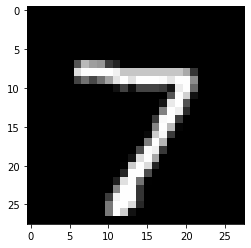

In [93]:
plt.imshow(x_imagem_teste.reshape((28,28)), cmap ='gray')